In [86]:
import networkx as nx
import utils
import time
import matplotlib.pyplot as plt
import pandas as pd
import Graph_Exploration
import pickle
import Louvain_algo

Load the graphs

In [36]:
def small_G():
    G = nx.Graph()

    # Add nodes
    G.add_node(1)
    G.add_nodes_from([1,2, 3, 4, 5, 6, 7, 8, 9])

    # Add edges
    G.add_edges_from([(1,2),(1, 3),(2,3), (3,6),(3,7),(3,9),(4,5),(4,7),(4,8),(5,7),(5,8),(6,9),(7,8),(8,9)])
    return G
small_graph = small_G()

In [37]:
def email():
    graph = nx.read_edgelist("data/email-Eu-core.txt", nodetype = int)
    s = list(nx.connected_components(graph))
    G = graph.subgraph(s[0])
    return G
email_graph = email()

In [38]:
def citation():
    graph = nx.read_edgelist("data/CA-GrQc.txt", nodetype = int)
    s = list(nx.connected_components(graph))
    G = graph.subgraph(s[0])
    return G
citation_graph = citation()

In [39]:
nodes,edges = utils.Load_data("nodes with communities.csv","edges without loops.csv")
facebook_graph = utils.Create_Graph(nodes=nodes , edges=edges)

Apply louvain built in:

In [40]:

def louvain_built_in(G):
    start_time = time.time()
    communities_built = nx.community.louvain_communities(G)
    t = time.time()-start_time
    return t
def louvain_built_in_n(G):
    start_time = time.time()
    communities_built = nx.community.louvain_communities(G)
    t = time.time()-start_time
    return communities_built

In [53]:
graphs = [small_graph,email_graph,citation_graph,facebook_graph]

data_dict = {
    'names': ['small_graph','email_graph','citation_graph','facebook_graph'],
    'nodes': [G.number_of_nodes() for G in graphs],
    'edges': [G.number_of_edges() for G in graphs],
    'louvain_build_in': [louvain_built_in(G) for G in graphs],
    'louvain_build_in_n': [louvain_built_in_n(G) for G in graphs]
}

Cutsize

In [43]:
#Adding the community id to the graphs as attributes
def add_community_ids(G,node_lists,attribute):
    for i, nodes in enumerate(node_lists):
        for node in nodes:
            # Here you can set any attribute
            G.nodes[node][attribute] = i
    return G
for i,graph in enumerate(graphs):
    graph = add_community_ids(graph,data_dict['louvain_build_in_n'][i],"community_id")

In [60]:
data_dict['cut_size_louvain_built'] = [Graph_Exploration.get_cut_sizes(g,com_id="community_id") for g in graphs]
data_dict['cut_size_louvain_built'] 

[2.0, 1583.0, 64.84444444444445, 680.6129032258065]

Modularity

In [61]:
data_dict['louvain_modularity'] = [nx.community.modularity(G,com) for G, com in zip(graphs,data_dict['louvain_build_in_n'])]
data_dict['louvain_modularity']

[0.35714285714285715,
 0.4278626973875356,
 0.8482975382159322,
 0.8136048871896867]

Add the own implementation

In [87]:
with open('data/com0_81054', 'rb') as file:
    # Load the object from the file
    louvain_own= pickle.load(file)
mod = nx.community.modularity(facebook_graph,list(louvain_own.values()))
print(mod)

0.8103398079339845


In [91]:
def apply_own(G):
    start_time = time.time()
    algo = Louvain_algo.Louvain_algo(G,1)
    com = algo.run()
    t = time.time()-start_time
    return t,com

In [94]:
data_dict['own_time'] = []
data_dict['own_com'] =  []
for G in graphs:
    t,com = apply_own(G)
    data_dict['own_time'].append(t)
    data_dict['own_com'].append(com)

In [96]:
data_dict['own_time']

[6.222724914550781e-05,
 0.06723952293395996,
 0.051760196685791016,
 0.07395124435424805]

Plotting

In [62]:
df  =pd.DataFrame(data_dict)
df

,names,nodes,edges,louvain_build_in,louvain_build_in_n,louvain_modularity,cut_size_louvain_built
0,small_graph,9,14,0.000620,"[{1, 2, 3, 6, 9}, {8, 4, 5, 7}]",0.357143,2.000000
1,email_graph,986,16687,0.228014,"[{0, 1, 512, 519, 524, 17, 18, 20, 21, 22, 533...",0.427863,1583.000000
2,citation_graph,4158,13428,0.746335,"[{17923, 1028, 8710, 14854, 13322, 8718, 24593...",0.848298,64.844444
3,facebook_graph,22470,170823,3.830687,"[{6404, 12041, 20746, 13327, 14352, 11025, 174...",0.813605,680.612903


In [65]:
def plot_G(x_axis,y_axis,title):
    plt.scatter(df[x_axis], df[y_axis])
    for i, txt in enumerate(df['names']):
        plt.annotate(txt, (df[x_axis][i], df[y_axis][i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

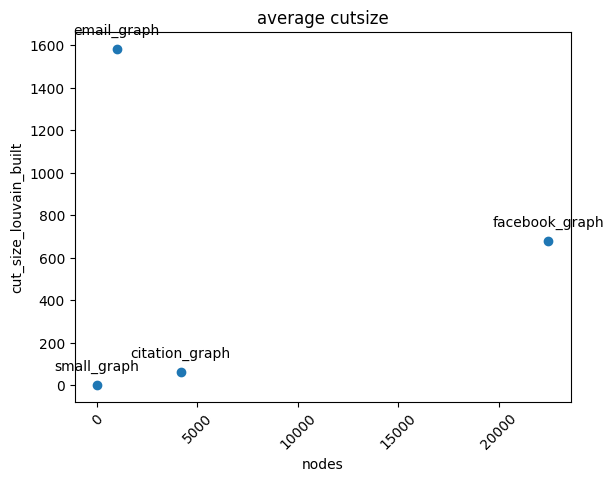

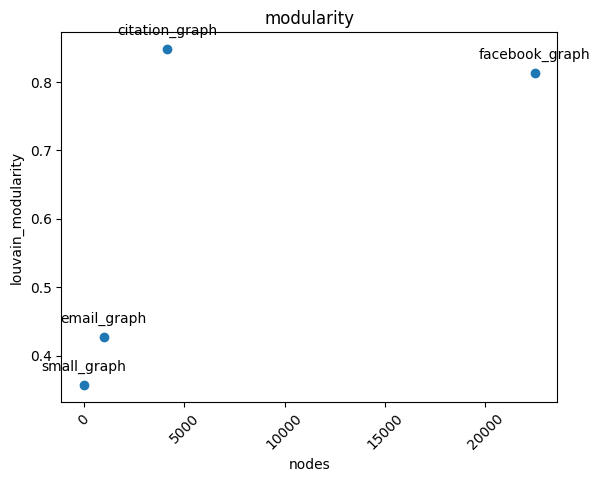

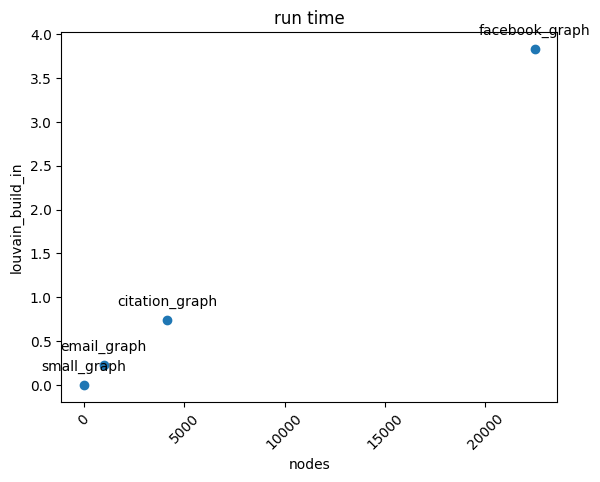

In [75]:
plot_G('nodes','cut_size_louvain_built','average cutsize')
plot_G('nodes','louvain_modularity','modularity')
plot_G('nodes','louvain_build_in','run time')

In [97]:
def apply_girvan_newman(G):
    start_time = time.time()
    girvan_newman = nx.community.girvan_newman(G)
    com = []
    old_mod = 0
    for level, comm_at_level in enumerate(girvan_newman):
        comm_at_level_sorted= sorted(comm_at_level, key=len, reverse=True)
        com.append(comm_at_level)
        new_mod = nx.community.modularity(G,comm_at_level_sorted)
        #print(new_mod)
        #print(com)
        if new_mod<(old_mod + 0.02):
            if new_mod<old_mod:
                best = -2
            else:
                best = -1
            break 
        old_mod = new_mod
        print([len(comm) for comm in comm_at_level_sorted])
    t = time.time()-start_time
    return t,com[best]

In [98]:
t,com = apply_girvan_newman(small_graph)
print(t,com)

[5, 4]
0.002608776092529297 ({1, 2, 3, 6, 9}, {8, 4, 5, 7})


In [99]:
data_dict['girvan_time'] = []
data_dict['girvan_com'] = []
for G in graphs:
    t,com = apply_girvan_newman(G)
    data_dict['girvan_time'].append(t)
    data_dict['girvan_com'].append(com)
    print("finished with",str(G))
    print("time",data_dict['girvan_time'])
    print("results",data_dict['girvan_com'])


[5, 4]
finished with Graph with 9 nodes and 14 edges
time [0.00479435920715332]
results [({1, 2, 3, 6, 9}, {8, 4, 5, 7})]
finished with Graph with 986 nodes and 16687 edges
time [0.00479435920715332, 80.95442533493042]
results [({1, 2, 3, 6, 9}, {8, 4, 5, 7}), ({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 16

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fd4ccaa2350>>
Traceback (most recent call last):
  File "/home/deborah/FS24/social_media/project/project-git/Social-Media-Analytics---Project/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [62]:
def plot_Girvan(G):
    comm_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    pos = nx.spring_layout(G)
    node_sizes = [(G.degree(v))**2 / 10 for v in G]
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, node_size=node_sizes, width=0.025, node_color='tab:blue', edgecolors='k')
    plt.show()

    girvan_newman = nx.community.girvan_newman(G)

    for level, comm_at_level in enumerate(girvan_newman):
        comm_at_level_sorted = sorted(comm_at_level, key=len, reverse=True)
        print([len(comm) for comm in comm_at_level_sorted])
        
        node_colors = {}
        for comm_idx, community in enumerate(comm_at_level_sorted):
            for node in community:
                node_colors[node] = comm_colors[comm_idx%(len(comm_colors)-1)]

        if level % 5 == 4:
            plt.figure(figsize=(8, 5))
            nx.draw(G, pos, with_labels=False, node_size=node_sizes, width=0.025, node_color=[node_colors[node] for node in G.nodes], edgecolors='k')
            plt.show()

In [70]:
import itertools

k = 8

comp = nx.community.girvan_newman(email_graph)

limited = itertools.takewhile(lambda c: len(c) <= k, comp)

for communities in limited:
    print(tuple(sorted(c) for c in communities))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221